<a href="https://colab.research.google.com/github/YOUNGSTER-SOHAIL/Telco-Customer-Churn-Prediction/blob/main/Project_2_Telco_Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [38]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC


Loading Data

In [18]:
# 2. Load Data

df = pd.read_csv("/content/telco_engineered.csv")
print("Shape:", df.shape)
df.head(3)


Shape: (7043, 36)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TenureYears,IsNewCustomer,PaperlessFlag,AutoPayFlag,HasFiber,HasStreaming,ServicesCount,ContractMonths,AvgMonthlyChargeSoFar,ChargeGrowthProxy,MonthlyToTotalRatio,SeniorDependent,TenureBucketNum,TotalChargesPerContractMonth,SeniorAlone
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0.083333,1,1,0,0,0,0,1,29.850000,0.000000,1.00000,0,0,29.850000,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,2.833333,0,0,0,0,0,1,12,55.573529,1.376471,0.03014,0,3,157.458333,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0.166667,1,1,0,0,0,1,1,54.075000,-0.225000,0.49792,0,0,108.150000,0


Exploratory Data Analysis


Missing values:
 0

Churn distribution:
 Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


/tmp/ipython-input-1467929803.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='coolwarm')


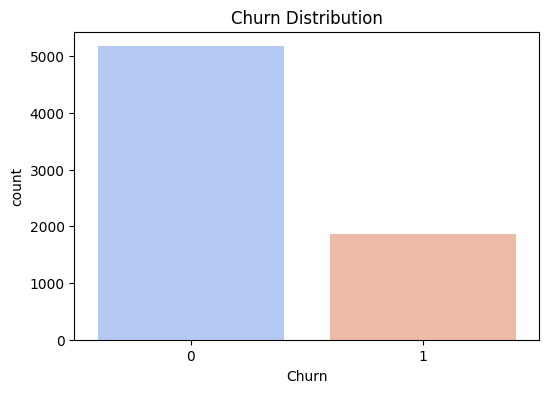

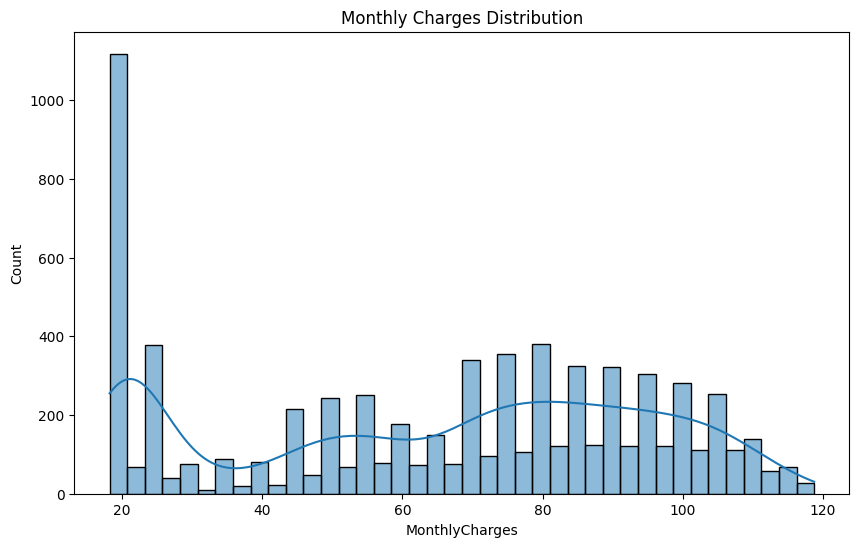

/tmp/ipython-input-1467929803.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='MonthlyCharges', data=df, palette='Set2')


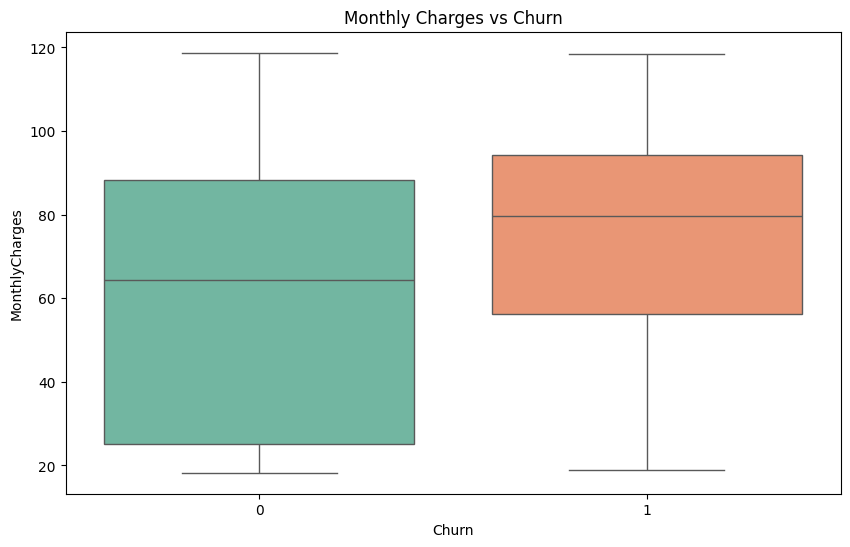


Duplicate Rows: 0


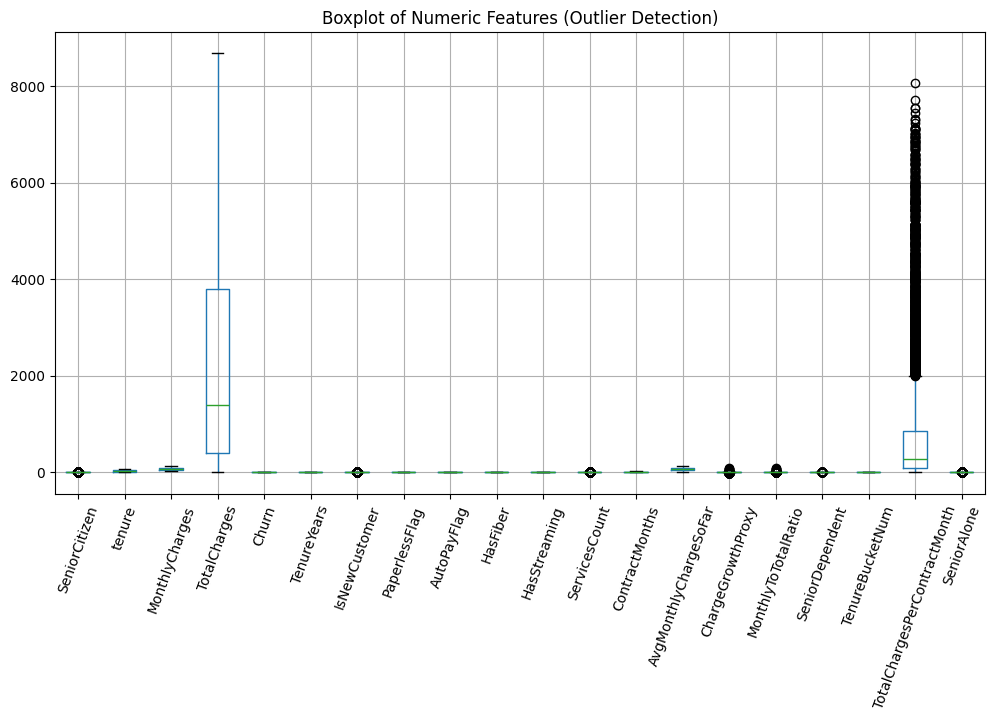

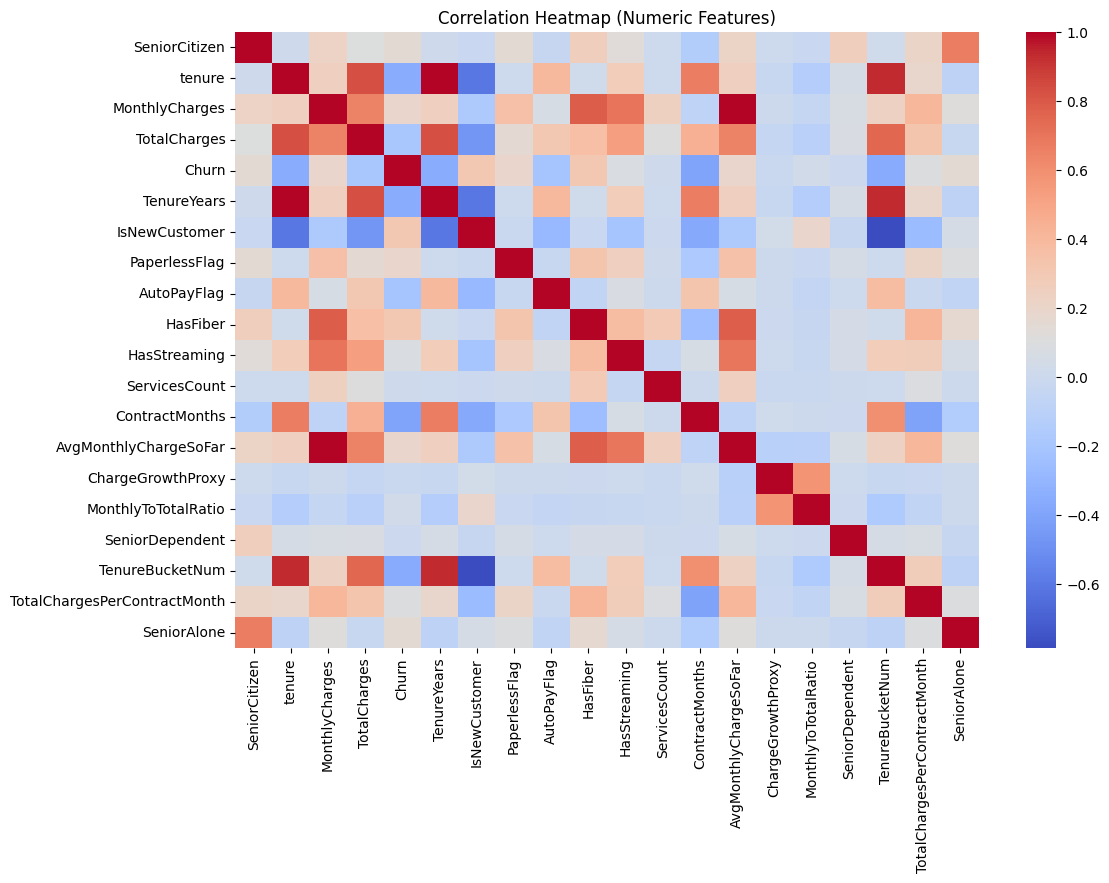

In [37]:
# 3. Basic EDA

print("\nMissing values:\n", df.isnull().sum().sum())
print("\nChurn distribution:\n", df['Churn'].value_counts(normalize=True))

plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df, palette='coolwarm')
plt.title("Churn Distribution")
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(df['MonthlyCharges'], bins=40, kde=True)
plt.title("Monthly Charges Distribution")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df, palette='Set2')
plt.title("Monthly Charges vs Churn")
plt.show()

# Duplicates
print("\nDuplicate Rows:", df.duplicated().sum())
df = df.drop_duplicates()

# Outlier Detection (Numeric)
num_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12,6))
df[num_cols].boxplot()
plt.title("Boxplot of Numeric Features (Outlier Detection)")
plt.xticks(rotation=70)
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df[num_cols].corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


Feature Split

In [31]:
# 4. Feature Split

X = df.drop(columns=['Churn', 'customerID'], errors="ignore")
y = df['Churn'].astype(int)

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("\nNumeric features:", numeric_features[:10])
print("Categorical features:", categorical_features[:10])


Numeric features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'TenureYears', 'IsNewCustomer', 'PaperlessFlag', 'AutoPayFlag', 'HasFiber', 'HasStreaming']
Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']


Preprocessing

In [32]:
# 5. Preprocessing

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
    ]
)

Train Test Split

In [33]:
# 6. Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


ML Models

In [34]:
# 7. Models

models = {
    "LogisticRegression": LogisticRegression(max_iter=200),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "SVC_RBF": SVC(kernel="rbf", probability=True, random_state=42)
}

results = []

Training & Evaluation

In [35]:
# 8. Training & Evaluation

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    results.append([name, acc, prec, rec, f1, auc])

    print(f"\n{name} Classification Report:\n", classification_report(y_test, y_pred))


LogisticRegression Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.53      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409


RandomForest Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409


GradientBoosting Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.51      0.58       374

    accuracy                           0.80      1409
   m

ROC Curve

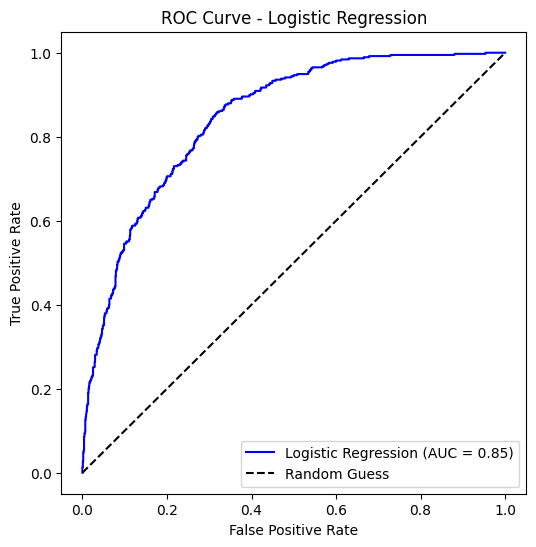

In [45]:
# Use the already trained Logistic Regression pipeline from evaluation loop
best_model = Pipeline(steps=[("preprocess", preprocess),
                             ("model", LogisticRegression(max_iter=200))])

best_model.fit(X_train, y_train)  # fit once properlybabilities for Logistic Regression

y_probs = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.show()


Results Summary


Model Comparison:
                 Model  Accuracy  Precision    Recall        F1   ROC_AUC
0  LogisticRegression  0.804116   0.664430  0.529412  0.589286  0.846850
1        RandomForest  0.790632   0.632997  0.502674  0.560358  0.829505
2    GradientBoosting  0.804116   0.672535  0.510695  0.580547  0.844225
3             SVC_RBF  0.797019   0.658273  0.489305  0.561350  0.802391


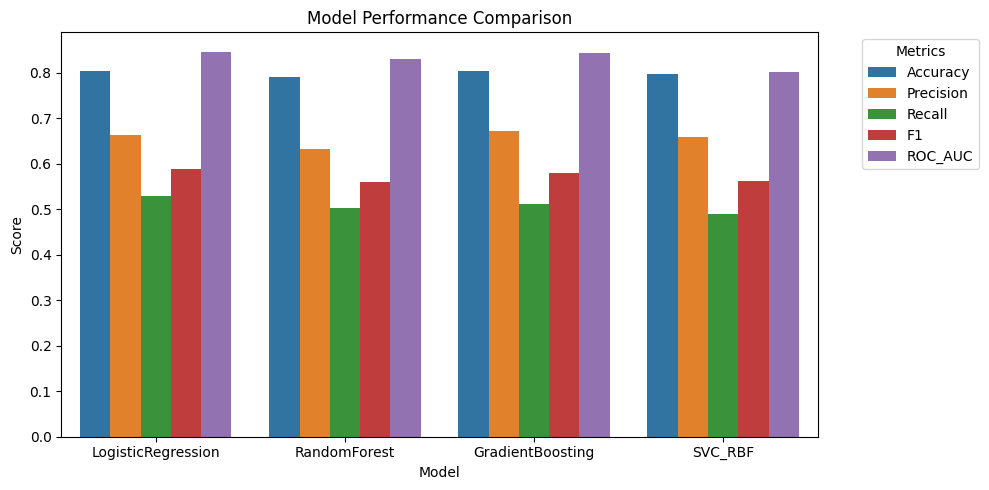

In [46]:
# 9. Results Summary
# Create DataFrame from results
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1", "ROC_AUC"])
print("\nModel Comparison:\n", results_df)

# Plot barplot
plt.figure(figsize=(10,5))
sns.barplot(
    data=results_df.melt(id_vars="Model", var_name="Metric", value_name="Score"),
    x="Model", y="Score", hue="Metric"
)
plt.title("Model Performance Comparison")

# Move legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Metrics")
plt.tight_layout()
plt.show()
